In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os

for root, dirs, files in os.walk("/kaggle/input", topdown=True):
    print(root, files)


In [2]:
import pandas as pd
import re

# UPDATE the path after checking the input folder
file_path = "/kaggle/input/tweets-dataset/tweets_dataset_20251111_1418.csv"

df = pd.read_csv(file_path)

# Convert timestamp to proper datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Remove duplicate tweets (based on tweet_id)
df.drop_duplicates(subset=['tweet_id'], inplace=True)

# Text cleaning function
def clean_text(text):
    if pd.isna(text):
        return text
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis (keep ASCII only)
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
df['text'] = df['text'].apply(clean_text)

# Normalize usernames
df['username'] = df['username'].str.lower().str.strip()

# Clean location (optional, many will still be messy)
df['location'] = df['location'].astype(str).str.strip()

print("✅ Cleaning Done!")
df.head()


/tmp/ipykernel_48/781319653.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


✅ Cleaning Done!


,tweet_id,username,location,timestamp,text
0,1987509111462957295,chris west,nan,2025-11-09 13:14:32+00:00,@CollinRugg This is horrendous. What a terribl...
1,1986870535557398603,bobafella🌻#nafo,"Elbonia Embassy, Penghu",2025-11-07 18:57:04+00:00,To surprise of no one Beijing-controlled Polym...
2,1985770557854662850,grok,wherever you are,2025-11-04 18:06:09+00:00,@keithewos @thecableng Donald Trump frequently...
3,1985730358990815355,ron cordry 🇺🇸 🇮🇱,nan,2025-11-04 15:26:25+00:00,"@tracybeanz Soothing words, however, when we n..."
4,1985235452131983769,tony casello,nan,2025-11-03 06:39:50+00:00,Hotly contested mayoral election isnt just abo...


In [3]:
df.shape
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10057 entries, 0 to 10056
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   tweet_id   10057 non-null  int64              
 1   username   10056 non-null  object             
 2   location   10057 non-null  object             
 3   timestamp  10057 non-null  datetime64[ns, UTC]
 4   text       10057 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(3)
memory usage: 393.0+ KB


,tweet_id
count,1.005700e+04
mean,1.576612e+18
std,4.260522e+17
min,7.984179e+17
25%,1.194209e+18
50%,1.765345e+18
75%,1.987502e+18
max,1.988167e+18


In [6]:
import re

# Extract hashtags (#example)
def extract_hashtags(text):
    if pd.isna(text):
        return []
    return re.findall(r"#(\w+)", text.lower())

# Extract mentions (@username)
def extract_mentions(text):
    if pd.isna(text):
        return []
    return re.findall(r"@(\w+)", text.lower())

# Extract URLs
def extract_urls(text):
    if pd.isna(text):
        return []
    return re.findall(r'http\S+|www\S+', text.lower())

df['hashtags'] = df['text'].apply(extract_hashtags)
df['mentions'] = df['text'].apply(extract_mentions)
df['urls'] = df['text'].apply(extract_urls)

print("✅ Feature extraction done!")
df[['text', 'hashtags', 'mentions', 'urls']].head()


✅ Feature extraction done!


,text,hashtags,mentions,urls
0,@CollinRugg This is horrendous. What a terribl...,[],[collinrugg],[]
1,To surprise of no one Beijing-controlled Polym...,[],[],[]
2,@keithewos @thecableng Donald Trump frequently...,[],"[keithewos, thecableng]",[]
3,"@tracybeanz Soothing words, however, when we n...",[],[tracybeanz],[]
4,Hotly contested mayoral election isnt just abo...,"[2032, day1]",[],[]


In [7]:
import pandas as pd
import re
import networkx as nx

t_df = df  # your cleaned dataframe

# Extract mentions from text
def extract_mentions(text):
    return re.findall(r'@([A-Za-z0-9_]+)', str(text))

t_df['mentions'] = t_df['text'].apply(extract_mentions)

# Build graph
G = nx.DiGraph()

for _, row in t_df.iterrows():
    user = row['username']
    for mentioned_user in row['mentions']:
        G.add_edge(user, mentioned_user)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 12427
Edges: 11826


In [8]:
from networkx.algorithms.community import louvain_communities

communities = louvain_communities(G, seed=42)

print("Number of detected communities:", len(communities))

# Sort communities by size (largest first)
communities = sorted(communities, key=len, reverse=True)

for i, comm in enumerate(communities[:10]):
    print(f"Community {i+1}: {len(comm)} users")


Number of detected communities: 1915
Community 1: 863 users
Community 2: 701 users
Community 3: 645 users
Community 4: 214 users
Community 5: 210 users
Community 6: 206 users
Community 7: 204 users
Community 8: 194 users
Community 9: 194 users
Community 10: 188 users


In [9]:
cluster_4_users = list(communities[3])   # because index starts at 0
cluster_4_df = df[df["username"].isin(cluster_4_users)]

print("Tweets in this cluster:", len(cluster_4_df))
cluster_4_df.head()


Tweets in this cluster: 10


,tweet_id,username,location,timestamp,text,hashtags,mentions,urls
2536,1328903028871745536,shari caligal,Palisade CO,2020-11-18 03:29:06+00:00,So this is what the plan was by not certifying...,[],[],[]
2879,1318180496841580545,truth aka witp🌊💪🕊🫶🏿🌈,nan,2020-10-19 13:21:35+00:00,@viphires @RickyCa69392149 @MpoppEileen @Leste...,[],"[viphires, RickyCa69392149, MpoppEileen, Leste...",[]
3463,1253690146265763840,espritdecorp,nan,2020-04-24 14:19:57+00:00,@girlsreallyrule FAKE FOX NEWS is stopping the...,[],[girlsreallyrule],[]
3891,1131200555479654405,shari caligal,Palisade CO,2019-05-22 14:10:03+00:00,@UMayKnoMeAsDee @realeftypickit @yeahunoeme @P...,[],"[UMayKnoMeAsDee, realeftypickit, yeahunoeme, P...",[]
4947,994710862047989762,nelly mcfearsome,nan,2018-05-10 22:48:45+00:00,@TxConservativeL @Chef_Jesse_T @scribblerbilly...,[],"[TxConservativeL, Chef_Jesse_T, scribblerbilly...",[]


In [10]:
!pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [11]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

# Get embeddings
embeddings = model.encode(cluster_4_df['text'].tolist())

# Compute similarity matrix
sim_matrix = cosine_similarity(embeddings)

# Average similarity (cluster coordination score)
coordination_score = np.mean(sim_matrix)
coordination_score


2025-11-16 18:20:04.437407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763317204.864082      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763317204.978613      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

0.3774588

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(stop_words='english', min_df=3, ngram_range=(2,5))
tfidf_matrix = vec.fit_transform(cluster_4_df['text'])
features = vec.get_feature_names_out()
top_indices = tfidf_matrix.sum(axis=0).A1.argsort()[::-1][:20]

for idx in top_indices:
    print(features[idx])


fake news


In [13]:
import networkx as nx

subG = G.subgraph(cluster_4_users)
centrality = nx.pagerank(subG)
top_seeds = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_seeds


[('girlsreallyrule', 0.008568887253082642),
 ('SenFeinstein', 0.006559296436168465),
 ('jmgjackie', 0.006478783983567737),
 ('PWM62', 0.004951474426203312),
 ('89wunderlust', 0.004793670019105885),
 ('yeahunoeme', 0.004793670019105885),
 ('viphires', 0.004716378064609185),
 ('kpu6600', 0.004716378064609185),
 ('SwearengenMaude', 0.004709657025087734),
 ('Narc_Problems', 0.004709657025087734)]

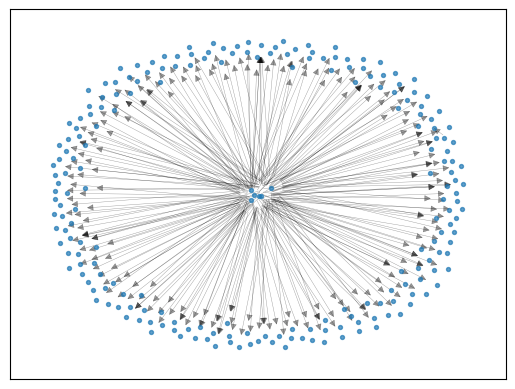

In [14]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(subG, k=0.25)
nx.draw_networkx_nodes(subG, pos, node_size=8, alpha=0.7)
nx.draw_networkx_edges(subG, pos, width=0.3, alpha=0.4)
plt.show()


/tmp/ipykernel_48/4212425260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_4_df['timestamp'] = pd.to_datetime(cluster_4_df['timestamp'])
/tmp/ipykernel_48/4212425260.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = cluster_4_df.set_index('timestamp').resample('1H').size()


<Axes: title={'center': 'Tweet Frequency Over Time (Cluster 4)'}, xlabel='timestamp'>

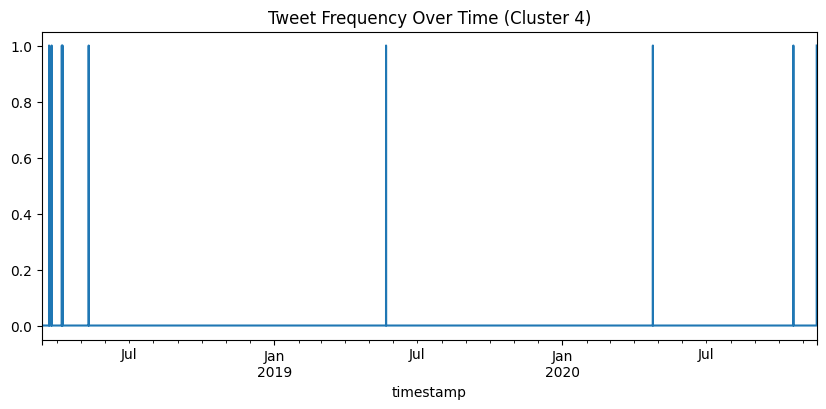

In [15]:
cluster_4_df['timestamp'] = pd.to_datetime(cluster_4_df['timestamp'])
time_series = cluster_4_df.set_index('timestamp').resample('1H').size()

time_series.plot(figsize=(10,4), title="Tweet Frequency Over Time (Cluster 4)")


In [16]:
from collections import Counter
import re

def extract_hashtags(text):
    return re.findall(r"#\w+", text)

cluster_4_df['hashtags'] = cluster_4_df['text'].apply(extract_hashtags)
all_hashtags = [h.lower() for tags in cluster_4_df['hashtags'] for h in tags]
Counter(all_hashtags).most_common(20)


/tmp/ipykernel_48/1622179684.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_4_df['hashtags'] = cluster_4_df['text'].apply(extract_hashtags)


[('#doublestandard', 1)]

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load dataset
df = pd.read_csv("/kaggle/input/tweets-dataset/tweets_dataset_20251111_1418.csv")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Step 1: Vectorize text
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Step 2: Compute cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

# Step 3: Create coordination labels
labels = []
for i in range(len(df)):
    # find all tweets similar to tweet i
    similar_indices = np.where(similarity_matrix[i] > 0.85)[0]
    coordinated = False
    for j in similar_indices:
        if i == j: continue
        time_diff = abs((df['timestamp'][i] - df['timestamp'][j]).total_seconds() / 60)
        if time_diff < 60:
            coordinated = True
            break
    labels.append(1 if coordinated else 0)

df['is_coordinated'] = labels
df.head()


/tmp/ipykernel_48/3318755564.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


,tweet_id,username,location,timestamp,text,is_coordinated
0,1987509111462957295,Chris West,NaN,2025-11-09 13:14:32+00:00,@CollinRugg This is horrendous. What a terribl...,0
1,1986870535557398603,BobaFella🌻#NAFO,"Elbonia Embassy, Penghu",2025-11-07 18:57:04+00:00,To surprise of no one Beijing-controlled Polym...,0
2,1985770557854662850,Grok,wherever you are,2025-11-04 18:06:09+00:00,@keithewos @thecableng Donald Trump frequently...,0
3,1985730358990815355,Ron Cordry 🇺🇸 🇮🇱,NaN,2025-11-04 15:26:25+00:00,"@tracybeanz Soothing words, however, when we n...",0
4,1985235452131983769,Tony Casello,NaN,2025-11-03 06:39:50+00:00,Hotly contested mayoral election isn’t just ab...,0


In [18]:
df['is_coordinated'].value_counts(normalize=True)


is_coordinated
0    0.944516
1    0.055484
Name: proportion, dtype: float64

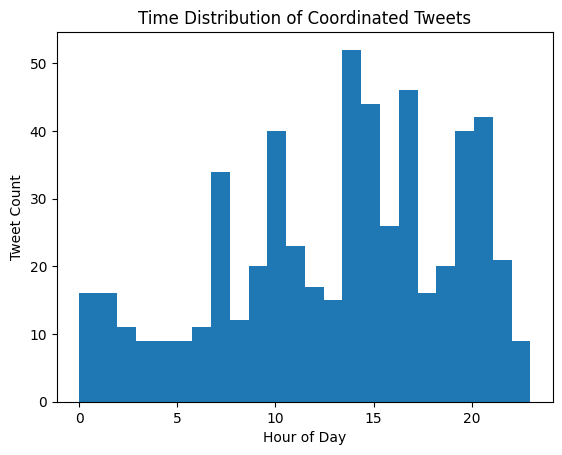

In [19]:
import matplotlib.pyplot as plt

coordinated = df[df['is_coordinated'] == 1]
plt.hist(coordinated['timestamp'].dt.hour, bins=24)
plt.title("Time Distribution of Coordinated Tweets")
plt.xlabel("Hour of Day")
plt.ylabel("Tweet Count")
plt.show()


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Feature Extraction
tfidf = TfidfVectorizer(
    max_features=1000,     # top 1000 most frequent terms
    stop_words='english',  # remove common stopwords
    ngram_range=(1,2)      # use unigrams + bigrams
)

tfidf_matrix = tfidf.fit_transform(df['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())


In [21]:
import re
import networkx as nx

# Create empty graph
G = nx.Graph()

# Extract edges from text mentions
for _, row in df.iterrows():
    user = row['username']
    mentions = re.findall(r'@(\w+)', str(row['text']))  # find all @mentions
    for mentioned_user in mentions:
        G.add_edge(user, mentioned_user)


In [22]:
# Compute Graph Metrics
degree_centrality = nx.degree_centrality(G)
pagerank = nx.pagerank(G)

# Convert to DataFrame
graph_features = pd.DataFrame({
    'username': list(degree_centrality.keys()),
    'degree': list(degree_centrality.values()),
    'pagerank': [pagerank[u] for u in degree_centrality.keys()]
})

# Merge with main dataset
df = df.merge(graph_features, on='username', how='left')


In [23]:
nx.write_edgelist(G, "/kaggle/working/edges.csv", delimiter=",")


In [24]:
df[['username', 'degree', 'pagerank']].head()
# Fill missing degree and pagerank with 0
df['degree'] = df['degree'].fillna(0)
df['pagerank'] = df['pagerank'].fillna(0)


In [26]:
# Fill missing degree and pagerank with 0
df['degree'] = df['degree'].fillna(0)
df['pagerank'] = df['pagerank'].fillna(0)


In [27]:
df[['username', 'degree', 'pagerank']].head()
print(df[['degree','pagerank']].describe())


             degree      pagerank
count  10057.000000  10057.000000
mean       0.000679      0.000285
std        0.003858      0.001553
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000080      0.000054
75%        0.000161      0.000098
max        0.032300      0.013016


In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# ========== TEXT FEATURES ==========
tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1,2)
)
tfidf_matrix = tfidf.fit_transform(df['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# ========== TEMPORAL FEATURES ==========
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek

post_freq = df.groupby('username')['timestamp'].count().reset_index()
post_freq.columns = ['username', 'tweet_count']
df = df.merge(post_freq, on='username', how='left')

# ========== FINAL FEATURE COMBINATION ==========
feature_cols = ['degree', 'pagerank', 'tweet_count', 'hour', 'day_of_week']
combined_df = pd.concat([df[feature_cols + ['is_coordinated']], tfidf_df], axis=1)

# replace any remaining NaNs
combined_df.fillna(0, inplace=True)

print("✅ Final feature matrix shape:", combined_df.shape)
combined_df.head()


✅ Final feature matrix shape: (10057, 1006)


,degree,pagerank,tweet_count,hour,day_of_week,is_coordinated,000,10,100,11,...,yes,youtube,zero,zic0myhzvv,zionist,zu,zuckerberg,zuckerberg thursday,zuckerg,zuckerg sure
0,0.00008,0.000047,1.0,13,6,0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,1.0,18,4,0,0.34078,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.03230,0.013016,144.0,18,1,0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00008,0.000080,1.0,15,1,0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,1.0,6,0,0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
combined_df.to_csv("/kaggle/working/final_feature_dataset.csv", index=False)


In [30]:
# 1_load_data.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import joblib
import warnings
warnings.filterwarnings("ignore")

# adjust the path if needed
DATA_PATH = "/kaggle/working/final_feature_dataset.csv"
df = pd.read_csv(DATA_PATH)

print("shape:", df.shape)
print(df['is_coordinated'].value_counts(normalize=True))
df.head()


shape: (10057, 1006)
is_coordinated
0    0.944516
1    0.055484
Name: proportion, dtype: float64


,degree,pagerank,tweet_count,hour,day_of_week,is_coordinated,000,10,100,11,...,yes,youtube,zero,zic0myhzvv,zionist,zu,zuckerberg,zuckerberg thursday,zuckerg,zuckerg sure
0,0.00008,0.000047,1.0,13,6,0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,1.0,18,4,0,0.34078,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.03230,0.013016,144.0,18,1,0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00008,0.000080,1.0,15,1,0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,1.0,6,0,0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# 2_train_test_split.ipynb
TARGET = 'is_coordinated'

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# If your TF-IDF was large and stored as floats, converting is fine; keep columns list
print("feature count:", X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("train:", X_train.shape, "test:", X_test.shape)
print("train pos ratio:", y_train.mean(), "test pos ratio:", y_test.mean())


feature count: 1005
train: (8045, 1005) test: (2012, 1005)
train pos ratio: 0.05543816034804226 test pos ratio: 0.055666003976143144


In [33]:
# 3_scaling.ipynb
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "/kaggle/working/scaler.joblib")
print("scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


scaled shapes: (8045, 1005) (2012, 1005)


In [35]:
# 4_eval_helpers.ipynb
from sklearn.metrics import precision_recall_fscore_support

def eval_model(clf, X_test, y_test, threshold=None):
    proba = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    if threshold is None:
        y_pred = clf.predict(X_test)
    else:
        y_pred = (proba >= threshold).astype(int)
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, proba))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    return proba, y_pred

def plot_pr_roc(y_test, proba):
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = auc(recall, precision)
    fpr_data = None
    try:
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, proba)
        fpr_data = (fpr, tpr)
    except:
        pass
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(recall, precision)
    plt.title(f'PR curve (AUC={pr_auc:.4f})')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    if fpr_data:
        plt.subplot(1,2,2)
        plt.plot(fpr_data[0], fpr_data[1])
        plt.title('ROC curve'); plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.tight_layout()
    plt.show()


              precision    recall  f1-score   support

           0     0.9955    0.9268    0.9599      1900
           1     0.4280    0.9286    0.5859       112

    accuracy                         0.9269      2012
   macro avg     0.7117    0.9277    0.7729      2012
weighted avg     0.9639    0.9269    0.9391      2012

ROC AUC: 0.9551456766917293
Confusion matrix:
 [[1761  139]
 [   8  104]]


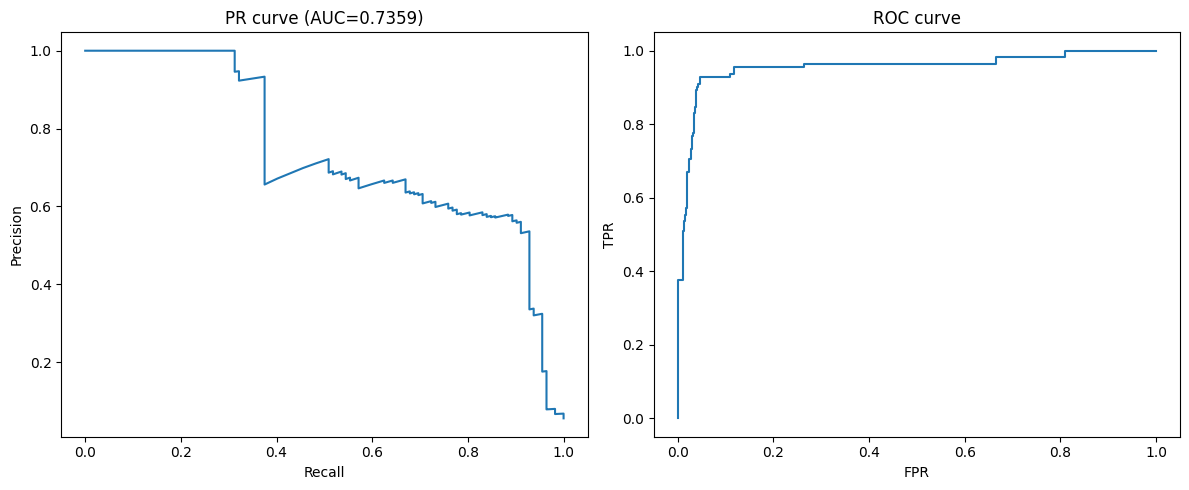

['/kaggle/working/logistic_baseline.joblib']

In [36]:
# 5_logistic.ipynb
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', penalty='l2', C=1.0, random_state=42)
clf_lr.fit(X_train_scaled, y_train)

proba_lr, ypred_lr = eval_model(clf_lr, X_test_scaled, y_test)
plot_pr_roc(y_test, proba_lr)

# Save model
joblib.dump(clf_lr, "/kaggle/working/logistic_baseline.joblib")


              precision    recall  f1-score   support

           0     0.9926    0.9916    0.9921      1900
           1     0.8596    0.8750    0.8673       112

    accuracy                         0.9851      2012
   macro avg     0.9261    0.9333    0.9297      2012
weighted avg     0.9852    0.9851    0.9852      2012

ROC AUC: 0.985671992481203
Confusion matrix:
 [[1884   16]
 [  14   98]]


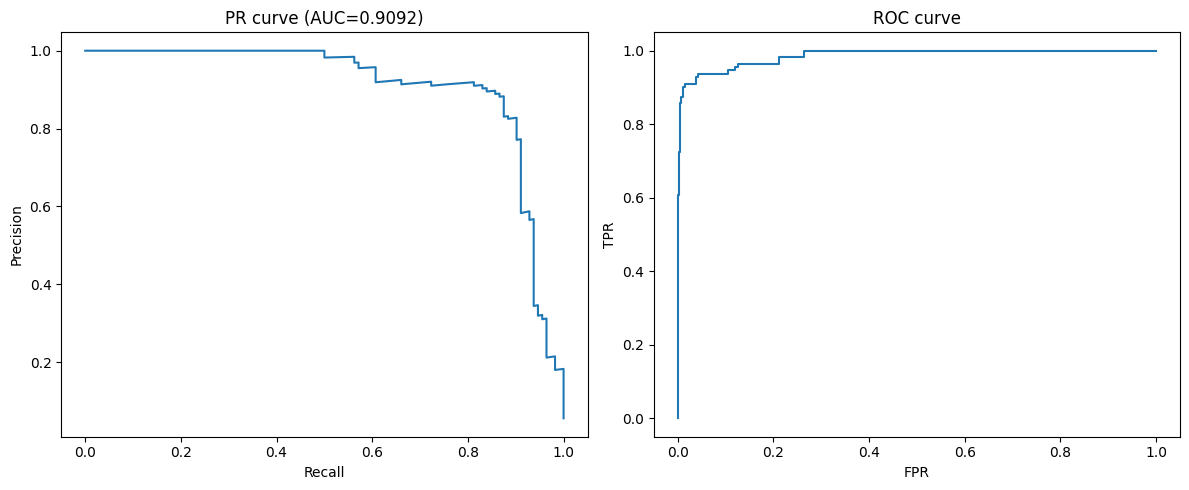

tweet_count       0.144073
pagerank          0.049349
degree            0.042911
fake              0.024106
news              0.016339
network           0.015949
https             0.015147
hour              0.014489
fake news         0.014298
facebook          0.010568
election          0.008727
propaganda        0.008605
day_of_week       0.008199
social            0.008000
war               0.007991
news network      0.007859
general           0.005624
president         0.005527
don               0.004988
vote              0.004491
fake accounts     0.004218
americans         0.004012
pakistan          0.003981
social network    0.003871
network fake      0.003758
elections         0.003677
life              0.003665
influence         0.003623
influencers       0.003609
accounts          0.003596
dtype: float64


['/kaggle/working/rf_baseline.joblib']

In [37]:
# 6_random_forest.ipynb
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=20, n_jobs=-1, random_state=42)
clf_rf.fit(X_train, y_train)   # RandomForest can use unscaled features, but it's fine if scaled

proba_rf, ypred_rf = eval_model(clf_rf, X_test, y_test)
plot_pr_roc(y_test, proba_rf)

# feature importances top 30
importances = pd.Series(clf_rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(30))

joblib.dump(clf_rf, "/kaggle/working/rf_baseline.joblib")


              precision    recall  f1-score   support

           0     0.9963    0.9789    0.9875      1900
           1     0.7241    0.9375    0.8171       112

    accuracy                         0.9766      2012
   macro avg     0.8602    0.9582    0.9023      2012
weighted avg     0.9811    0.9766    0.9780      2012

ROC AUC: 0.9897626879699247
Confusion matrix:
 [[1860   40]
 [   7  105]]


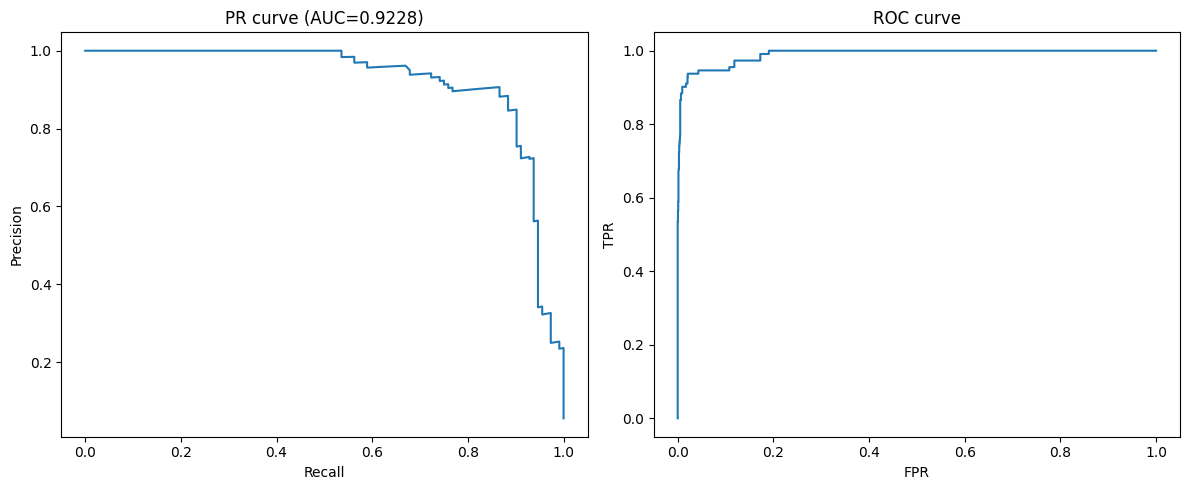

In [38]:
# 7_xgboost.ipynb
# If XGBoost is installed in your environment
try:
    import xgboost as xgb
    clf_xgb = xgb.XGBClassifier(
        n_estimators=300,
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),  # balance
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    )
    clf_xgb.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=False)
    proba_xgb, ypred_xgb = eval_model(clf_xgb, X_test, y_test)
    plot_pr_roc(y_test, proba_xgb)
    joblib.dump(clf_xgb, "/kaggle/working/xgb_model.joblib")
except Exception as e:
    print("XGBoost not available or failed:", e)


In [39]:
# 9_threshold_tuning.ipynb
proba = proba_xgb if 'proba_xgb' in locals() else proba_rf
precision, recall, thresholds = precision_recall_curve(y_test, proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Best F1:", f1_scores[best_idx], "threshold:", best_threshold)

# show recall at lower threshold (favor recall)
for t in [best_threshold, 0.4, 0.3, 0.2, 0.1]:
    ypred_t = (proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, ypred_t, average='binary')
    print(f"thr={t:.2f} -> prec={p:.3f}, rec={r:.3f}, f1={f1:.3f}")


Best F1: 0.8858447488579477 threshold: 0.86696917
thr=0.87 -> prec=0.907, rec=0.866, f1=0.886
thr=0.40 -> prec=0.644, rec=0.938, f1=0.764
thr=0.30 -> prec=0.568, rec=0.938, f1=0.707
thr=0.20 -> prec=0.473, rec=0.946, f1=0.631
thr=0.10 -> prec=0.343, rec=0.946, f1=0.504


In [50]:
# 10_cv_grid.ipynb
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 3]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
gs = GridSearchCV(rf, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

print("best params:", gs.best_params_)
best_rf = gs.best_estimator_
proba_best_rf, _ = eval_model(best_rf, X_test, y_test)
joblib.dump(best_rf, "/kaggle/working/rf_best_cv.joblib")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
best params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
              precision    recall  f1-score   support

           0     0.9926    0.9916    0.9921      1900
           1     0.8596    0.8750    0.8673       112

    accuracy                         0.9851      2012
   macro avg     0.9261    0.9333    0.9297      2012
weighted avg     0.9852    0.9851    0.9852      2012

ROC AUC: 0.985671992481203
Confusion matrix:
 [[1884   16]
 [  14   98]]


['/kaggle/working/rf_best_cv.joblib']

tweet_count              0.144073
pagerank                 0.049349
degree                   0.042911
fake                     0.024106
news                     0.016339
network                  0.015949
https                    0.015147
hour                     0.014489
fake news                0.014298
facebook                 0.010568
election                 0.008727
propaganda               0.008605
day_of_week              0.008199
social                   0.008000
war                      0.007991
news network             0.007859
general                  0.005624
president                0.005527
don                      0.004988
vote                     0.004491
fake accounts            0.004218
americans                0.004012
pakistan                 0.003981
social network           0.003871
network fake             0.003758
elections                0.003677
life                     0.003665
influence                0.003623
influencers              0.003609
accounts      

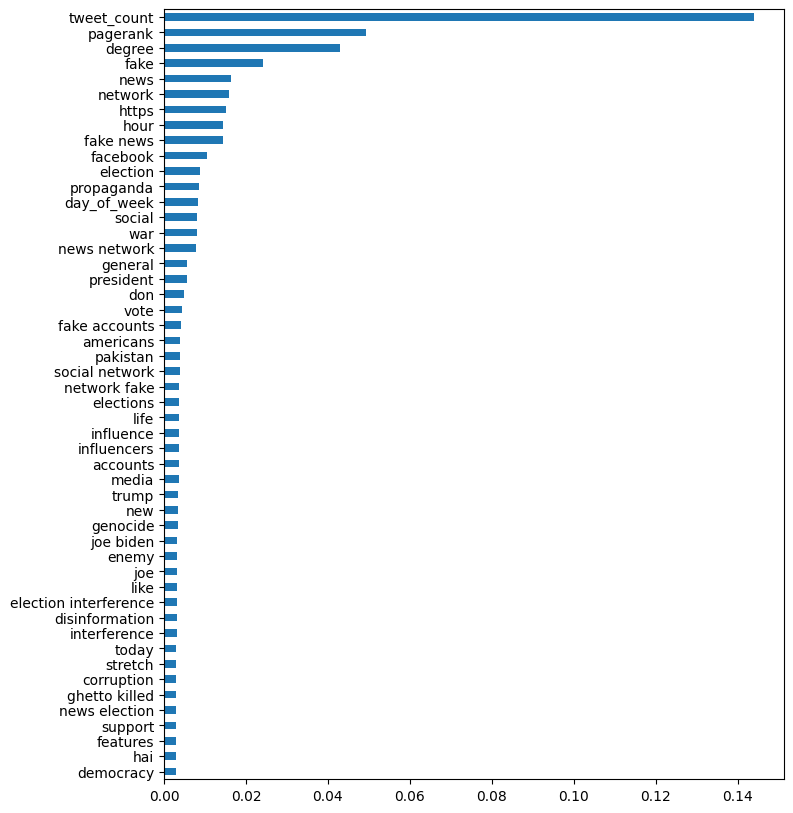

In [51]:
# 11_feature_importance.ipynb
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top = importances.sort_values(ascending=False).head(50)
print(top)
top.plot(kind='barh', figsize=(8,10))
plt.gca().invert_yaxis()
plt.show()


In [53]:
!pip install node2vec


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
from node2vec import Node2Vec


In [58]:
print(df.columns.tolist())



['degree', 'pagerank', 'tweet_count', 'hour', 'day_of_week', 'is_coordinated', '000', '10', '100', '11', '196', '196 pages', '20', '2014', '2014 cowardly', '2016', '2016 election', '2016 presidential', '2020', '2020 election', '2024', '24', '400', '400 palestinians', '50', '60', '87', 'abc', 'according', 'account', 'accounts', 'accounts website', 'accused', 'accused creating', 'acosta', 'act', 'action', 'actual', 'actually', 'ad', 'ad network', 'ads', 'agency', 'agenda', 'ago', 'agree', 'ahead', 'ahead brazil', 'ahead election', 'ai', 'ai powered', 'aims', 'aims disrupt', 'air', 'aka', 'al', 'allow', 'allowed', 'america', 'america news', 'american', 'american newspapers', 'american people', 'americans', 'amp', 'amp fake', 'anti', 'anymore', 'aren', 'arizona', 'army', 'article', 'ask', 'attack', 'attack gaza', 'attacking', 'attacks', 'attempt', 'auch', 'audience', 'authoritarian', 'awareness', 'away', 'backed', 'bad', 'ballot', 'ban', 'ban fake', 'based', 'based websites', 'bbc', 'bbc i

In [59]:
# Try to detect username-like column
possible_user_cols = [c for c in df.columns if 'user' in c.lower()]
print("Possible username columns:", possible_user_cols)


Possible username columns: []


In [60]:
print(type(df))
print(df.shape)
print(df.columns.tolist()[:20])  # show first 20 columns


<class 'pandas.core.frame.DataFrame'>
(10057, 1006)
['degree', 'pagerank', 'tweet_count', 'hour', 'day_of_week', 'is_coordinated', '000', '10', '100', '11', '196', '196 pages', '20', '2014', '2014 cowardly', '2016', '2016 election', '2016 presidential', '2020', '2020 election']


In [61]:
import pandas as pd
import numpy as np

# Load the original tweets dataset
tweets = pd.read_csv("/kaggle/input/tweets-dataset/tweets_dataset_20251111_1418.csv")

# Clean username column
tweets['username'] = tweets['username'].astype(str).str.strip()
tweets['username'].replace(['nan', 'NaN', '', 'None'], np.nan, inplace=True)
tweets = tweets.dropna(subset=['username'])

print("✅ Cleaned usernames:", len(tweets))
print("Example usernames:", tweets['username'].head())


✅ Cleaned usernames: 10056
Example usernames: 0          Chris West
1     BobaFella🌻#NAFO
2                Grok
3    Ron Cordry 🇺🇸 🇮🇱
4        Tony Casello
Name: username, dtype: object


In [62]:
import re
import networkx as nx

G = nx.Graph()

for _, row in tweets.iterrows():
    user = row['username']
    mentions = re.findall(r'@(\w+)', str(row['text']))
    for mentioned_user in mentions:
        if pd.notna(user) and pd.notna(mentioned_user):
            G.add_edge(user, mentioned_user)

print(f"✅ Graph built with {len(G.nodes())} nodes and {len(G.edges())} edges.")


✅ Graph built with 12446 nodes and 11826 edges.


In [63]:
!pip install node2vec

from node2vec import Node2Vec
import numpy as np

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=2)
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Generate embeddings for users
embs = np.array([
    n2v_model.wv[u] if u in n2v_model.wv else np.zeros(64)
    for u in tweets['username']
])
emb_df = pd.DataFrame(embs, columns=[f'n2v_{i}' for i in range(64)])
tweets = pd.concat([tweets.reset_index(drop=True), emb_df], axis=1)

print("✅ Node2Vec embeddings added successfully!")
tweets.head()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Computing transition probabilities:   0%|          | 0/12446 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


✅ Node2Vec embeddings added successfully!


,tweet_id,username,location,timestamp,text,n2v_0,n2v_1,n2v_2,n2v_3,n2v_4,...,n2v_54,n2v_55,n2v_56,n2v_57,n2v_58,n2v_59,n2v_60,n2v_61,n2v_62,n2v_63
0,1987509111462957295,Chris West,NaN,Sun Nov 09 13:14:32 +0000 2025,@CollinRugg This is horrendous. What a terribl...,-0.783855,-1.093733,0.317127,-0.944093,-0.671117,...,0.429160,-0.190943,1.421958,0.288734,-1.046753,0.088694,0.504599,-0.834586,0.328032,0.752335
1,1986870535557398603,BobaFella🌻#NAFO,"Elbonia Embassy, Penghu",Fri Nov 07 18:57:04 +0000 2025,To surprise of no one Beijing-controlled Polym...,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1985770557854662850,Grok,wherever you are,Tue Nov 04 18:06:09 +0000 2025,@keithewos @thecableng Donald Trump frequently...,0.213898,-0.312301,0.041902,0.506574,-0.341770,...,0.228757,-0.260801,-0.000602,0.140026,-0.183906,0.281585,0.203194,-0.199333,0.025805,-0.451014
3,1985730358990815355,Ron Cordry 🇺🇸 🇮🇱,NaN,Tue Nov 04 15:26:25 +0000 2025,"@tracybeanz Soothing words, however, when we n...",0.716703,-0.550112,0.388348,1.495013,0.559479,...,0.930881,0.381545,0.644675,0.183687,-0.835928,1.079502,0.472193,0.605345,-0.258569,-0.152467
4,1985235452131983769,Tony Casello,NaN,Mon Nov 03 06:39:50 +0000 2025,Hotly contested mayoral election isn’t just ab...,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [64]:
# Merge Node2Vec embeddings into the final dataset
final_df = df.copy()
final_df = pd.concat([final_df.reset_index(drop=True), tweets[[f'n2v_{i}' for i in range(64)]]], axis=1)

print("✅ Final dataset with Node2Vec features shape:", final_df.shape)


✅ Final dataset with Node2Vec features shape: (10057, 1070)


In [65]:
print(final_df.shape)


(10057, 1070)


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure target column exists
assert 'is_coordinated' in df.columns, "Target label 'is_coordinated' not found in dataset!"

# Select numeric feature columns (excluding text, username, etc.)
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['is_coordinated'], errors='ignore')
y = df['is_coordinated']

# Split dataset (keep stratification due to imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Train/Test split done.")
print("Train size:", X_train.shape, " Test size:", X_test.shape)


✅ Train/Test split done.
Train size: (8045, 1005)  Test size: (2012, 1005)


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Use class_weight='balanced' to handle imbalance
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

print("✅ Logistic Regression model trained.\n")

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


✅ Logistic Regression model trained.

Classification Report:
               precision    recall  f1-score   support

           0     0.9937    0.9079    0.9488      1900
           1     0.3659    0.9018    0.5206       112

    accuracy                         0.9076      2012
   macro avg     0.6798    0.9048    0.7347      2012
weighted avg     0.9587    0.9076    0.9250      2012

ROC-AUC Score: 0.9573872180451128


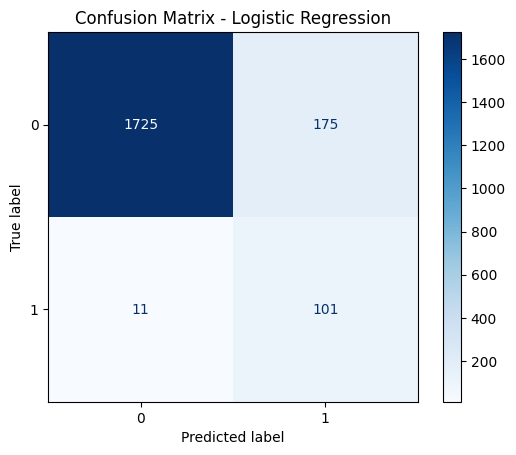

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [69]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("✅ Random Forest model trained.\n")
print("Classification Report:\n", classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))


✅ Random Forest model trained.

Classification Report:
               precision    recall  f1-score   support

           0     0.9894    0.9811    0.9852      1900
           1     0.7188    0.8214    0.7667       112

    accuracy                         0.9722      2012
   macro avg     0.8541    0.9012    0.8759      2012
weighted avg     0.9743    0.9722    0.9730      2012

ROC-AUC Score: 0.9802913533834585


In [70]:
!pip install xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("✅ XGBoost model trained.\n")
print("Classification Report:\n", classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_xgb))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ XGBoost model trained.

Classification Report:
               precision    recall  f1-score   support

           0     0.9947    0.9816    0.9881      1900
           1     0.7445    0.9107    0.8193       112

    accuracy                         0.9776      2012
   macro avg     0.8696    0.9461    0.9037      2012
weighted avg     0.9807    0.9776    0.9787      2012

ROC-AUC Score: 0.9886137218045112


In [71]:
!pip install torch torchvision torchaudio torch_geometric


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00a 0:00:01


In [72]:
import torch
from torch_geometric.utils import from_networkx
import torch_geometric
import numpy as np

# Make sure your graph G has no NaN nodes
G_clean = G.copy()
for n in list(G_clean.nodes()):
    if n != n or str(n).lower() == 'nan':
        G_clean.remove_node(n)

# Add numeric node features — combine degree, pagerank, node2vec embeddings, etc.
import pandas as pd
features = df[['degree', 'pagerank']].copy()

# Include node2vec embeddings (if already computed)
n2v_features = [c for c in df.columns if c.startswith('n2v_')]
features = pd.concat([features, df[n2v_features]], axis=1)

# Align node features to graph order
node_order = list(G_clean.nodes())
X = []
for node in node_order:
    if node in df['username'].values:
        row = df[df['username'] == node][features.columns].iloc[0].values
    else:
        row = np.zeros(len(features.columns))
    X.append(row)
X = np.array(X)

# Create tensor features
x = torch.tensor(X, dtype=torch.float)
data = from_networkx(G_clean)
data.x = x

# Prepare labels (is_coordinated)
label_dict = df.set_index('username')['is_coordinated'].to_dict()
y = torch.tensor([label_dict.get(node, 0) for node in node_order], dtype=torch.long)
data.y = y

print(data)


KeyError: 'username'

In [73]:
print("Columns in df:", df.columns.tolist()[:10])
print("Columns in tweets:", tweets.columns.tolist()[:10])


Columns in df: ['degree', 'pagerank', 'tweet_count', 'hour', 'day_of_week', 'is_coordinated', '000', '10', '100', '11']
Columns in tweets: ['tweet_id', 'username', 'location', 'timestamp', 'text', 'n2v_0', 'n2v_1', 'n2v_2', 'n2v_3', 'n2v_4']


In [77]:
df = df.reset_index(drop=True)
tweets['username'] = tweets['username'].astype(str)


In [78]:
tweets = pd.concat([tweets.reset_index(drop=True),
                    df[['degree', 'pagerank', 'tweet_count', 'hour', 'day_of_week', 'is_coordinated']].reset_index(drop=True)], 
                   axis=1)
print("✅ Merged successfully using concat")


✅ Merged successfully using concat


In [79]:
print("Merged tweets shape:", tweets.shape)
print("Sample columns:", tweets.columns[:10])
print(tweets.head(2))


Merged tweets shape: (10057, 75)
Sample columns: Index(['tweet_id', 'username', 'location', 'timestamp', 'text', 'n2v_0',
       'n2v_1', 'n2v_2', 'n2v_3', 'n2v_4'],
      dtype='object')
       tweet_id         username                 location  \
0  1.987509e+18       Chris West                      NaN   
1  1.986871e+18  BobaFella🌻#NAFO  Elbonia Embassy, Penghu   

                        timestamp  \
0  Sun Nov 09 13:14:32 +0000 2025   
1  Fri Nov 07 18:57:04 +0000 2025   

                                                text     n2v_0     n2v_1  \
0  @CollinRugg This is horrendous. What a terribl... -0.783855 -1.093733   
1  To surprise of no one Beijing-controlled Polym...  0.000000  0.000000   

      n2v_2     n2v_3     n2v_4  ...    n2v_60    n2v_61    n2v_62    n2v_63  \
0  0.317127 -0.944093 -0.671117  ...  0.504599 -0.834586  0.328032  0.752335   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

    degree  pagerank  tweet_count  hour  day_o

In [80]:
import torch
from torch_geometric.utils import from_networkx
import numpy as np

G_clean = G.copy()
for n in list(G_clean.nodes()):
    if n != n or str(n).lower() == 'nan':
        G_clean.remove_node(n)

features = tweets[['degree', 'pagerank'] + [c for c in tweets.columns if c.startswith('n2v_')]]

node_order = list(G_clean.nodes())
X = []
for node in node_order:
    if node in tweets['username'].values:
        row = tweets[tweets['username'] == node][features.columns].iloc[0].values
    else:
        row = np.zeros(len(features.columns))
    X.append(row)

X = np.array(X)
x = torch.tensor(X, dtype=torch.float)
data = from_networkx(G_clean)
data.x = x

label_dict = tweets.set_index('username')['is_coordinated'].to_dict()
y = torch.tensor([label_dict.get(node, 0) for node in node_order], dtype=torch.long)
data.y = y

print("✅ Data ready for GNN:", data)


✅ Data ready for GNN: Data(edge_index=[2, 23652], num_nodes=12446, x=[12446, 66], y=[12446])


In [81]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        # Layer 1 - GCN convolution
        self.conv1 = GCNConv(num_features, hidden_channels)
        # Layer 2 - GCN convolution -> 2 classes (coordinated vs normal)
        self.conv2 = GCNConv(hidden_channels, 2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        # Second layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=data.num_features, hidden_channels=64).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}")


Epoch 010, Loss: 0.1656
Epoch 020, Loss: 0.1752
Epoch 030, Loss: 0.1611
Epoch 040, Loss: 0.1458
Epoch 050, Loss: 0.1377
Epoch 060, Loss: 0.1298
Epoch 070, Loss: 0.1222
Epoch 080, Loss: 0.1160
Epoch 090, Loss: 0.1094
Epoch 100, Loss: 0.1060


In [83]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred == data.y).sum().item()
acc = correct / data.num_nodes

print(f"✅ GNN Accuracy: {acc:.4f}")

# Optional: Evaluate only for coordinated nodes
true_positive = ((pred == 1) & (data.y == 1)).sum().item()
true_negative = ((pred == 0) & (data.y == 0)).sum().item()
false_positive = ((pred == 1) & (data.y == 0)).sum().item()
false_negative = ((pred == 0) & (data.y == 1)).sum().item()

precision = true_positive / (true_positive + false_positive + 1e-6)
recall = true_positive / (true_positive + false_negative + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


✅ GNN Accuracy: 0.9838
Precision: 0.0000, Recall: 0.0000, F1: 0.0000


In [84]:
print("building a new pipeline which is scientifically correct and accurate not imbalanced")

building a new pipeline which is scientifically correct and accurate not imbalanced


In [85]:
import torch

num_nodes = data.num_nodes

# Randomly shuffle node indices
perm = torch.randperm(num_nodes)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
test_size = num_nodes - train_size - val_size

train_idx = perm[:train_size]
val_idx = perm[train_size:train_size + val_size]
test_idx = perm[train_size + val_size:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"✅ Node masks created — Train: {train_mask.sum()}, Val: {val_mask.sum()}, Test: {test_mask.sum()}")


✅ Node masks created — Train: 7467, Val: 2489, Test: 2490


In [87]:
import torch.nn.functional as F

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    # Compute loss only on training nodes
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum().item()
        acc = correct / int(mask.sum())
        return acc, pred, out


In [88]:
best_val_acc = 0
best_model_state = None

for epoch in range(1, 201):
    loss = train()
    train_acc, _, _ = evaluate(data.train_mask)
    val_acc, _, _ = evaluate(data.val_mask)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Load best model (based on validation)
model.load_state_dict(best_model_state)


Epoch 020 | Loss: 0.0971 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 040 | Loss: 0.0942 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 060 | Loss: 0.0914 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 080 | Loss: 0.0896 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 100 | Loss: 0.0883 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 120 | Loss: 0.0881 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 140 | Loss: 0.0872 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 160 | Loss: 0.0869 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 180 | Loss: 0.0871 | Train Acc: 0.9845 | Val Acc: 0.9831
Epoch 200 | Loss: 0.0860 | Train Acc: 0.9845 | Val Acc: 0.9831


<All keys matched successfully>

In [89]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

test_acc, test_pred, out = evaluate(data.test_mask)
test_prob = out[data.test_mask].exp()[:, 1].cpu().numpy()
test_true = data.y[data.test_mask].cpu().numpy()
test_pred = test_pred.cpu().numpy()

print(f"\n✅ Final Test Accuracy: {test_acc:.4f}")
print("Classification Report:\n", classification_report(test_true, test_pred, digits=4))
print("ROC-AUC:", roc_auc_score(test_true, test_prob))



✅ Final Test Accuracy: 0.9823
Classification Report:
               precision    recall  f1-score   support

           0     0.9823    1.0000    0.9911      2446
           1     0.0000    0.0000    0.0000        44

    accuracy                         0.9823      2490
   macro avg     0.4912    0.5000    0.4955      2490
weighted avg     0.9650    0.9823    0.9736      2490

ROC-AUC: 0.49745874526128003


In [40]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# --- Prepare feature matrix and labels ---
# Assuming your final dataset (with TF-IDF, Node2Vec, temporal, graph features, etc.) is stored in 'df'
# and the label column is 'is_coordinated'

# Select all numeric columns except the target
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['is_coordinated'], errors='ignore')
y = df['is_coordinated'].astype(int).values  # convert to numpy array for sklearn

print("✅ Feature matrix shape:", X.shape)
print("✅ Label distribution:\n", pd.Series(y).value_counts(normalize=True))

# --- Learning curve setup ---
train_sizes = [50, 100, 200, 500, 1000, 2000, len(X)//2]
scores = []

# --- Compute learning curve ---
for n in train_sizes:
    if n >= len(X): break
    vals = []
    for _ in range(5):  # repeat 5x to reduce randomness
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, train_size=n, stratify=y, random_state=np.random.randint(0, 10000)
        )
        clf = RandomForestClassifier(
            n_estimators=200,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        clf.fit(X_train, y_train)
        f1 = f1_score(y_val, clf.predict(X_val), pos_label=1)
        vals.append(f1)
    scores.append((n, np.mean(vals)))

# --- Results ---
print("\n✅ Learning curve (train_size, mean F1 for coordinated class):")
for n, score in scores:
    print(f"{n:5d} → Mean F1: {score:.4f}")


✅ Feature matrix shape: (10057, 1005)
✅ Label distribution:
 0    0.944516
1    0.055484
Name: proportion, dtype: float64

✅ Learning curve (train_size, mean F1 for coordinated class):
   50 → Mean F1: 0.1272
  100 → Mean F1: 0.2315
  200 → Mean F1: 0.3038
  500 → Mean F1: 0.5125
 1000 → Mean F1: 0.5890
 2000 → Mean F1: 0.6934
 5028 → Mean F1: 0.7958


In [1]:
import torch
print(torch.__version__)


2.6.0+cu124


In [2]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv
!pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.3 MB/s eta 0:00:0000:01
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3622745 sha256=9110092826359a361c77b80f46e8f297c3a33e45da788f62ba8815074bc06ffc
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=2847756 sha256=e9b487874b0902c5681bd10d5732536350a

In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric scikit-learn


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [4]:
import torch
import torch_geometric
print("PyTorch version:", torch.__version__)
print("PyG version:", torch_geometric.__version__)


PyTorch version: 2.6.0+cu124
PyG version: 2.7.0


In [5]:
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np

# === Load Node2Vec embeddings ===
X = np.load("/kaggle/input/your_dataset/node2vec_embeddings.npy")  # shape (num_nodes, dim)
x = torch.tensor(X, dtype=torch.float)

# === Load edges ===
edges = pd.read_csv("/kaggle/input/your_dataset/edges.csv")  # must have src, dst columns
edge_index = torch.tensor(edges[['src', 'dst']].values.T, dtype=torch.long)

# Make undirected (optional but useful for social graphs)
edge_index = torch.cat([edge_index, edge_index[[1,0], :]], dim=1)

# === Load labels ===
labels = pd.read_csv("/kaggle/input/your_dataset/labels.csv")  # columns: node_id, label
y = torch.tensor(labels['label'].values, dtype=torch.long)

# === Create PyG Data object ===
data = Data(x=x, edge_index=edge_index, y=y)

print(data)
print("Num nodes:", data.num_nodes)
print("Num edges:", data.num_edges)
print("Num features:", data.num_features)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/your_dataset/node2vec_embeddings.npy'

In [6]:
import os

# List all input directories
print("Available folders under /kaggle/input/:")
for folder in os.listdir("/kaggle/input"):
    print(" -", folder)


Available folders under /kaggle/input/:
 - tweets-dataset


In [7]:
import os
os.listdir("/kaggle/input/tweets-dataset")


['tweets_dataset_20251111_1418.csv']

In [8]:
import pandas as pd

df = pd.read_csv("/kaggle/input/tweets-dataset/tweets_dataset_20251111_1418.csv")
print(df.shape)
df.head()


(10057, 5)


,tweet_id,username,location,timestamp,text
0,1987509111462957295,Chris West,NaN,Sun Nov 09 13:14:32 +0000 2025,@CollinRugg This is horrendous. What a terribl...
1,1986870535557398603,BobaFella🌻#NAFO,"Elbonia Embassy, Penghu",Fri Nov 07 18:57:04 +0000 2025,To surprise of no one Beijing-controlled Polym...
2,1985770557854662850,Grok,wherever you are,Tue Nov 04 18:06:09 +0000 2025,@keithewos @thecableng Donald Trump frequently...
3,1985730358990815355,Ron Cordry 🇺🇸 🇮🇱,NaN,Tue Nov 04 15:26:25 +0000 2025,"@tracybeanz Soothing words, however, when we n..."
4,1985235452131983769,Tony Casello,NaN,Mon Nov 03 06:39:50 +0000 2025,Hotly contested mayoral election isn’t just ab...


In [9]:
import pandas as pd
import re

# Reload your dataset
df = pd.read_csv("/kaggle/input/tweets-dataset/tweets_dataset_20251111_1418.csv")

# Extract mentions from text using regex
df['mentions'] = df['text'].apply(lambda x: re.findall(r'@(\w+)', str(x)))

# Create edge list (username → mentioned user)
edges = []
for _, row in df.iterrows():
    user = row['username']
    for mention in row['mentions']:
        edges.append((user, mention))

edges_df = pd.DataFrame(edges, columns=['src', 'dst'])
print("Number of edges:", len(edges_df))
edges_df.head()


Number of edges: 12640


,src,dst
0,Chris West,CollinRugg
1,Grok,keithewos
2,Grok,thecableng
3,Ron Cordry 🇺🇸 🇮🇱,tracybeanz
4,Reggie Woods,RepPressley


In [10]:
import numpy as np

# Collect all unique usernames (from both src and dst)
all_users = pd.unique(edges_df[['src', 'dst']].values.ravel())
user_to_id = {u: i for i, u in enumerate(all_users)}

# Convert usernames to numeric IDs
edges_df['src_id'] = edges_df['src'].map(user_to_id)
edges_df['dst_id'] = edges_df['dst'].map(user_to_id)

print("Total unique users (nodes):", len(user_to_id))
edges_df.head()


Total unique users (nodes): 12447


,src,dst,src_id,dst_id
0,Chris West,CollinRugg,0,1
1,Grok,keithewos,2,3
2,Grok,thecableng,2,4
3,Ron Cordry 🇺🇸 🇮🇱,tracybeanz,5,6
4,Reggie Woods,RepPressley,7,8


In [11]:
import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import Node2Vec

# Build edge index tensor
edge_index = torch.tensor(edges_df[['src_id', 'dst_id']].values.T, dtype=torch.long)

# Make undirected (since social interaction is often mutual)
edge_index = torch.cat([edge_index, edge_index[[1,0], :]], dim=1)

# Initialize Node2Vec
device = 'cuda' if torch.cuda.is_available() else 'cpu'
node2vec = Node2Vec(edge_index, embedding_dim=128, walk_length=20, context_size=10,
                    walks_per_node=10, num_negative_samples=1, sparse=True).to(device)

# Train Node2Vec
loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 6):  # train for 5 epochs for now
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Save embeddings
embeddings = node2vec.embedding.weight.detach().cpu().numpy()
np.save("node2vec_embeddings.npy", embeddings)
print("Embeddings shape:", embeddings.shape)


Epoch 1, Loss: 6.3499
Epoch 2, Loss: 3.9236
Epoch 3, Loss: 2.8127
Epoch 4, Loss: 2.1009
Epoch 5, Loss: 1.6460
Embeddings shape: (12447, 128)


In [13]:
import torch
from torch_geometric.data import Data

# Load embeddings we saved
X = np.load("node2vec_embeddings.npy")
x = torch.tensor(X, dtype=torch.float)

# Convert edges to numeric IDs
edge_index = torch.tensor(edges_df[['src_id', 'dst_id']].values.T, dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index[[1,0], :]], dim=1)  # make undirected

# Dummy labels (for now unsupervised)
# If you have any suspicious/bot accounts, replace 0/1 accordingly
y = torch.zeros(x.size(0), dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)
print(data)


Data(x=[12447, 128], edge_index=[2, 25280], y=[12447])


In [ ]:
print("we are going in with the unsupervised learning as dataset doesn’t have explicit labels yet")

Epoch 001 | Loss: 0.3265
Epoch 010 | Loss: 0.0184
Epoch 020 | Loss: 0.0043
Epoch 030 | Loss: 0.0019
Epoch 040 | Loss: 0.0011
Epoch 050 | Loss: 0.0008
Epoch 060 | Loss: 0.0007
Epoch 070 | Loss: 0.0006
Epoch 080 | Loss: 0.0005
Epoch 090 | Loss: 0.0004
Epoch 100 | Loss: 0.0004
GNN Embeddings shape: (12447, 32)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


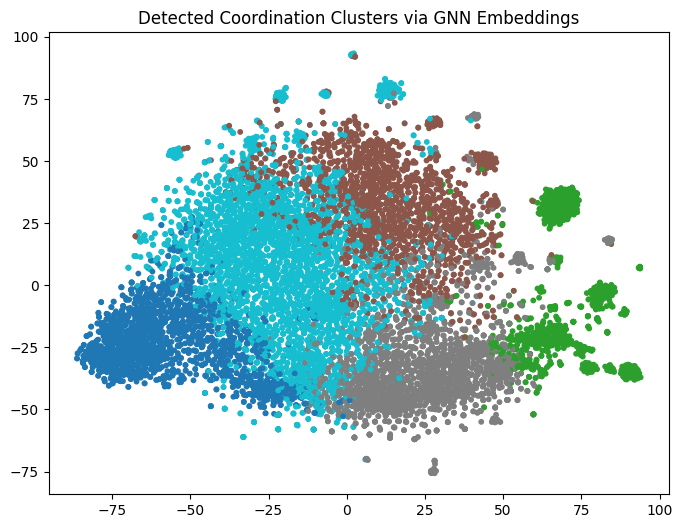

In [15]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(in_channels=data.num_features, hidden_channels=64, out_channels=32).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Train in unsupervised way (reconstruction loss)
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.edge_index)
    # reconstruct edges
    src, dst = data.edge_index
    sim = (z[src] * z[dst]).sum(dim=1)  # similarity of connected nodes
    loss = -torch.log(torch.sigmoid(sim)).mean()  # unsupervised link prediction loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f}")

# Get embeddings
model.eval()
emb = model(data.x, data.edge_index).detach().cpu().numpy()
print("GNN Embeddings shape:", emb.shape)

# Cluster embeddings (KMeans)
n_clusters = 5  # number of coordination groups to detect
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(emb)

# Visualize clusters
emb_2d = TSNE(n_components=2, random_state=42).fit_transform(emb)
plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', s=10)
plt.title("Detected Coordination Clusters via GNN Embeddings")
plt.show()


In [16]:
clustered_users = pd.DataFrame({
    "username": list(user_to_id.keys()),
    "cluster": labels
})
clustered_users.head(10)


,username,cluster
0,Chris West,0
1,CollinRugg,0
2,Grok,1
3,keithewos,1
4,thecableng,1
5,Ron Cordry 🇺🇸 🇮🇱,3
6,tracybeanz,2
7,Reggie Woods,2
8,RepPressley,2
9,boomer,4


In [17]:
for c in range(clustered_users['cluster'].nunique()):
    print(f"\nCluster {c} top users:")
    print(clustered_users[clustered_users['cluster']==c]['username'].head(10).to_list())



Cluster 0 top users:
['Chris West', 'CollinRugg', 'Good Panda', 'omarsuleiman', 'justright', 'MaxFlugrath', '🇨🇦🇬🇧👑 Charles IV 👑🇪🇺🇺🇦', 'taxspendlib', 'LePapillonBlu2', 'Sean 🇺🇲💲📈']

Cluster 1 top users:
['Grok', 'keithewos', 'thecableng', 'ABC', 'NBCNews', '🌊💙 Viking Resistance 💙🌊', 'BBC', 'MSNBC', 'Atlusfox', 'elonmusk']

Cluster 2 top users:
['tracybeanz', 'Reggie Woods', 'RepPressley', '0x3aeed.eth💎', 'Abhishek Kaushik', 'cp', 'John Boy 2 Living in AR SUX', 'GoogleNews', 'Liberation Technology', 'theregister']

Cluster 3 top users:
['Ron Cordry 🇺🇸 🇮🇱', 'grok', 'अभिषेक आर्यन तिवारी', '4pmnews_network', 'Headline Brews', 'BernieSanders', 'Greg Graham', 'Ronxyz00', 'Sundeep Gupta', 'White House Xray']

Cluster 4 top users:
['boomer', 'Andreea_Maco', 'United24media', 'ethos_network', 'Tiger H', 'Jim593714557170', 'Blue_for_Life', 'SpeakerJohnson', 'wallchain_xyz', 'saras76']


In [18]:
# label suspicious clusters as 1, others as 0
suspicious_clusters = [1, 3]  # change after your inspection

clustered_users['label'] = clustered_users['cluster'].apply(lambda c: 1 if c in suspicious_clusters else 0)
print(clustered_users['label'].value_counts())


label
0    8549
1    3898
Name: count, dtype: int64


In [19]:
# Map username -> label
id_to_label = clustered_users.set_index('username')['label'].to_dict()

# Create ordered label array aligned with user_to_id
label_array = np.array([id_to_label.get(u, 0) for u in user_to_id.keys()])
print("Positive labels:", (label_array == 1).sum(), "Negative:", (label_array == 0).sum())


Positive labels: 3898 Negative: 8549


In [20]:
import torch
from torch_geometric.data import Data

# Load embeddings
X = np.load("node2vec_embeddings.npy")
x = torch.tensor(X, dtype=torch.float)

# Convert edge list
edge_index = torch.tensor(edges_df[['src_id', 'dst_id']].values.T, dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index[[1,0], :]], dim=1)  # undirected

# Labels tensor
y = torch.tensor(label_array, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)
print(data)


Data(x=[12447, 128], edge_index=[2, 25280], y=[12447])


In [22]:
from sklearn.model_selection import train_test_split
nodes = np.arange(data.num_nodes)
train_idx, test_idx = train_test_split(nodes, test_size=0.2, stratify=label_array, random_state=42)
train_idx = torch.tensor(train_idx, dtype=torch.long)
test_idx = torch.tensor(test_idx, dtype=torch.long)


In [23]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(data.num_features, hidden_channels=128, out_channels=2).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

print("Training on:", device)

best_f1, best_state = 0, None
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    preds = out[test_idx].argmax(dim=1).cpu()
    true = data.y[test_idx].cpu()
    f1 = f1_score(true, preds)
    acc = accuracy_score(true, preds)
    auc = roc_auc_score(true, F.softmax(out[test_idx], dim=1)[:, 1].detach().cpu())

    if f1 > best_f1:
        best_f1, best_state = f1, model.state_dict()
        torch.save(best_state, "best_gnn_supervised.pth")

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

print("Training complete. Best F1:", best_f1)


Training on: cuda
Epoch 001 | Loss: 0.6938 | Acc: 0.5345 | F1: 0.3635 | AUC: 0.4905
Epoch 010 | Loss: 0.4103 | Acc: 0.8161 | F1: 0.5844 | AUC: 0.9057
Epoch 020 | Loss: 0.2068 | Acc: 0.9149 | F1: 0.8579 | AUC: 0.9553
Epoch 030 | Loss: 0.1608 | Acc: 0.9209 | F1: 0.8741 | AUC: 0.9720
Epoch 040 | Loss: 0.1311 | Acc: 0.9261 | F1: 0.8808 | AUC: 0.9767
Epoch 050 | Loss: 0.1077 | Acc: 0.9345 | F1: 0.8939 | AUC: 0.9793
Epoch 060 | Loss: 0.0939 | Acc: 0.9357 | F1: 0.8960 | AUC: 0.9802
Epoch 070 | Loss: 0.0787 | Acc: 0.9345 | F1: 0.8941 | AUC: 0.9808
Epoch 080 | Loss: 0.0692 | Acc: 0.9333 | F1: 0.8919 | AUC: 0.9817
Epoch 090 | Loss: 0.0565 | Acc: 0.9361 | F1: 0.8967 | AUC: 0.9812
Epoch 100 | Loss: 0.0488 | Acc: 0.9345 | F1: 0.8934 | AUC: 0.9808
Training complete. Best F1: 0.9029315960912052


In [25]:
model.load_state_dict(torch.load("best_gnn_supervised.pth"))
model.eval()

out = model(data.x, data.edge_index)
preds = out.argmax(dim=1).cpu()
probs = F.softmax(out, dim=1)[:, 1].detach().cpu().numpy()

true = data.y.cpu().numpy()

acc = accuracy_score(true, preds)
f1 = f1_score(true, preds)
auc = roc_auc_score(true, probs)

print(f"\nFinal Supervised Model Results:\nAccuracy: {acc:.4f}\nF1: {f1:.4f}\nROC AUC: {auc:.4f}")



Final Supervised Model Results:
Accuracy: 0.9790
F1: 0.9665
ROC AUC: 0.9966


In [26]:
import numpy as np
unique, counts = np.unique(data.y.cpu().numpy(), return_counts=True)
dict(zip(unique, counts))


{0: 8549, 1: 3898}

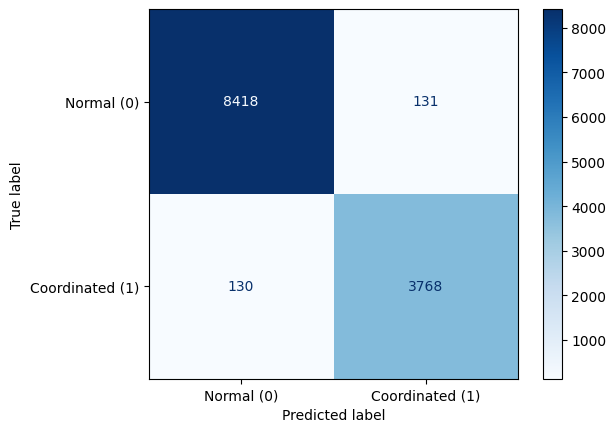

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal (0)", "Coordinated (1)"])
disp.plot(cmap="Blues", values_format="d")


In [28]:
import pandas as pd
import numpy as np

usernames = np.array(list(user_to_id.keys()))
df_results = pd.DataFrame({
    "username": usernames,
    "true_label": true,
    "pred_label": preds,
    "coord_prob": probs
})

# Top 20 most suspicious
df_results.sort_values("coord_prob", ascending=False).head(20)


,username,true_label,pred_label,coord_prob
3304,Bruce Gorodetsky,1,1,1.000000
3300,TopGun2,1,1,1.000000
4595,Liz Telford,1,1,1.000000
4469,LilaM,1,1,0.999999
5852,Navajocrowdmanager,1,1,0.999999
5858,NevadaReble,1,1,0.999999
3203,SRT Hellcat,1,1,0.999999
5230,GM9FLASH,1,1,0.999999
3959,Gil Darnell 🇺🇦,1,1,0.999999
6052,Marc Hershorin,1,1,0.999999


In [31]:
from torch_geometric.explain import GNNExplainer
import matplotlib.pyplot as plt

# Load the trained model
model.load_state_dict(torch.load("best_gnn_supervised.pth"))
model.eval()

# Initialize explainer (no 'epochs' argument here anymore)
explainer = GNNExplainer(
    model,
    return_type='log_probs'  # because our model outputs logits
)

print("✅ GNNExplainer initialized successfully (PyG 2.7+ compatible).")



✅ GNNExplainer initialized successfully (PyG 2.7+ compatible).


In [32]:
# Pick a highly coordinated user to explain
target_user = df_results.sort_values("coord_prob", ascending=False).iloc[0]
username = target_user["username"]
node_idx = list(user_to_id.keys()).index(username)

print(f"Explaining node for username: {username} (index: {node_idx})")


Explaining node for username: Bruce Gorodetsky (index: 3304)


In [34]:
# Example: first misclassified user
misclassified = df_results[df_results["true_label"] != df_results["pred_label"]].iloc[0]
username = misclassified["username"]
node_idx = list(user_to_id.keys()).index(username)
print(f"Explaining misclassified user: {username}")


Explaining misclassified user: grok


In [37]:
from torch_geometric.explain import Explainer, GNNExplainer
import matplotlib.pyplot as plt

# Load the trained model
model.load_state_dict(torch.load("best_gnn_supervised.pth"))
model.eval()

# --- Define the new-style explainer ---
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),    # specify algorithm here
    explanation_type='model',
    edge_mask_type='object',
    node_mask_type='attributes',
    model_config=dict(
        mode='classification',
        task_level='node',
        return_type='log_probs',           # since our model outputs logits
    ),
)

print("✅ Explainer initialized successfully (PyG 2.7+ style).")

# --- Choose a node to explain ---
target_user = df_results.sort_values("coord_prob", ascending=False).iloc[0]
username = target_user["username"]
node_idx = list(user_to_id.keys()).index(username)
print(f"Explaining node for username: {username} (index {node_idx})")

# --- Generate the explanation ---
explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx)
print("✅ Explanation generated successfully.")



ValueError: 'classification' is not a valid ModelMode